I have created this small python package to download [Sentinel-2](https://es.wikipedia.org/wiki/Sentinel-2) [Cloud Optimized Geotiffs (COGs)](https://en.wikipedia.org/wiki/GeoTIFF#Cloud_Optimised_GeoTIFF) from S3. [Sentinel-2](https://es.wikipedia.org/wiki/Sentinel-2) is a satellite operated by [ESA (European Space Agency)](https://es.wikipedia.org/wiki/Agencia_Espacial_Europea) and is part of the [Copernicus](https://es.wikipedia.org/wiki/Programa_Cop%C3%A9rnico) program (EU). The [Copernicus](https://es.wikipedia.org/wiki/Programa_Cop%C3%A9rnico) program is an ambitious project to look at our planet from the space. Sentinel-2 imagery are the simplest option to obtain high resolution imagery of the planet from several bands. With some lines of code you can download Gigabytes of information from the different bands obtained from Sentinel-2.

I will start importing some libs that we will use. If you want to follow this tutorial you will have to install `s2froms3`, `xarray`, `rasterio`, `pyepsg`, `cartopy`, `matplotlib`. If you have problems raise an issue and we will try to solve it.

In [1]:
import datetime as dt
from pathlib import Path

import xarray as xr
import s2froms3
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

I will use a location. I define the location using its latitude and its longitude:

In [2]:
lat, lon = 39.14151, 2.94708

As the (COGs) files are defined in tiles (divided using [MGRS](https://en.wikipedia.org/wiki/Military_Grid_Reference_System)) it could happen that my location would be located in a corner of the tile and, in the end, the region of interest wouldn't be centered. To kown where the location will be located within the tile you can use the function `point_in_tile` from `s2froms3`. You can use it like this:

In [32]:
print(s2froms3.point_in_tile(lon, lat))


+ + + + + + + + + + + 
+                   + 
+                   + 
+                   + 
+                   + 
+                   + 
+                   + 
+                 O + 
+                   + 
+                   + 
+ + + + + + + + + + + 



My location is located in the East area. If my location defines the center of the region of interest then maybe the file will not cover the complete region of interest. Later we will come back to this.

As I commented before we can obtain different products from Sentinel-2. To know what information is available to download we can use `s2froms3.products.Properties`:

In [3]:
for e in s2froms3.products.Properties:
    print(e.name)
    for k, v in e.describe().items():
        print(f"\t{k}: {v}")

TCI
	resolution: 10
	title: True color image
	center wavelength: None
B01
	resolution: 60
	title: Band 1 (coastal)
	center wavelength: 0.4439
B02
	resolution: 10
	title: Band 2 (blue)
	center wavelength: 0.4966
B03
	resolution: 10
	title: Band 3 (green)
	center wavelength: 0.56
B04
	resolution: 10
	title: Band 4 (red)
	center wavelength: 0.6645
B05
	resolution: 20
	title: Band 5
	center wavelength: 0.7039
B06
	resolution: 20
	title: Band 6
	center wavelength: 0.7402
B07
	resolution: 20
	title: Band 7
	center wavelength: 0.7825
B08
	resolution: 10
	title: Band 8 (nir)
	center wavelength: 0.8351
B8A
	resolution: 20
	title: Band 8A
	center wavelength: 0.8648
B09
	resolution: 60
	title: Band 9
	center wavelength: 0.945
B11
	resolution: 20
	title: Band 11 (swir16)
	center wavelength: 1.6137
B12
	resolution: 20
	title: Band 12 (swir22)
	center wavelength: 2.22024
AOT
	resolution: 60
	title: Aerosol Optical Thickness (AOT)
	center wavelength: None
WVP
	resolution: 10
	title: Water Vapour (WVP

En lo anterior veis que disponemos de varias bandas o productos derivados como el TCI (True Color). Se puede ver donde se centra la longitud de onda de la banda, la resolución de la imagen (en metros) y algo más de información. Dependiendo de lo que queramos analizar podemos usar unas bandas u otras o combinarlas de forma inteligente para obtener productos derivados. Las imágenes TCI se obtienen a partir de las bandas 4, 3 y 2, que serán las bandas espectrales del rojo, del verde y del azul, respectivamente, y se usan para obtener una imagen que vendría a representar como vemos los humanos (visible).

Tenemos, más o menos, todos los ingredientes que necesitamos. ¿Vamos a por los COGs? Para descargar los COGs podemos usar la función `download_S2`. El satélite Sentinel-2 es un satélite de órbita polar que va barriendo la tierra en pasadas de Sur a Norte y de Norte a Sur. Por tanto, no está mirando siempre sobre el mismo punto y puede que pasen varios días hasta que vuelva a pasar sobre la misma localización. Hemos de definir las fechas para descargar las imágenes, si el satélite no pasó sobre la localización durante esas fechas pues no habrá imágenes. Hemos de definir qué queremos descargar, qué bandas o productos. Hemos de definir la cubierta nubosa máxima admisible que queremos en la imagen ya que si hay nubes alguna información igual nos resulta menos útil. Etcétera.

Vamos con un ejemplo durante el verano boreal (estamos en el hemisferio Norte), periodo en el que suele haber menos nubes, y durante unas fechas que sé que ha pasado Sentinel-2 sobre mi área de interés. Por mantener esto sencillo voy a descargar TCI (imágenes *True Color*).

Definimos lo que necesitamos:

In [33]:
start_date = dt.date(2020, 7, 1) # Start date to search images
end_date = dt.date(2020, 7, 1) # End date to search images
what = ['TCI'] # What we want to download
cc = 25 # Minimum cloud cover on each image, 25 is 25%
folder = Path('.') # Where the files will be downloaded

Con la anterior información y con la localización definida más arriba puedo proceder a descargar las imágenes:

In [15]:
downloaded = s2froms3.download_S2(
    lon=lon,
    lat=lat,
    start_date=start_date,
    end_date=end_date,
    what=what,
    cloud_cover_le=cc,
    folder=folder,
    also=['E', 'NE', 'N'],
)

Con la opción `folder` defino donde quiero que se descarguen las imágenes. Con la opción `also` indico si, además, quiero descargar imágenes adyacentes a la tesela que estoy descargando. Le indico que sí, que quiero, además de la tesela que contiene a `lon` y `lat` también quiero las imágenes que se localizan en las teselas al Este, al Noreste y al Norte.

La función `download_S2` habrá descargado las imágenes y devuelve las rutas de esas imágenes en S3:

In [16]:
print(downloaded)

['sentinel-cogs/sentinel-s2-l2a-cogs/31/S/DD/2020/7/S2B_31SDD_20200701_0_L2A/TCI.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/31/S/ED/2020/7/S2B_31SED_20200701_0_L2A/TCI.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/31/T/DE/2020/7/S2B_31TDE_20200701_0_L2A/TCI.tif', 'sentinel-cogs/sentinel-s2-l2a-cogs/31/T/EE/2020/7/S2B_31TEE_20200701_0_L2A/TCI.tif']


Vamos a leer las imágenes que hemos descargado usando `xarray` (y `rasterio` entre bambalinas):

In [34]:
files = folder.glob("S2*.tif")

In [35]:
datasets = []

for f in files:
    datasets.append(xr.open_rasterio(f))

In [36]:
print(datasets)

[<xarray.DataArray (band: 3, y: 10980, x: 10980)>
[361681200 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 4.5e+06 4.5e+06 4.5e+06 ... 4.39e+06 4.39e+06 4.39e+06
  * x        (x) float64 5e+05 5e+05 5e+05 ... 6.098e+05 6.098e+05 6.098e+05
Attributes:
    transform:           (10.0, 0.0, 499980.0, 0.0, -10.0, 4500000.0)
    crs:                 +init=epsg:32631
    res:                 (10.0, 10.0)
    is_tiled:            1
    nodatavals:          (0.0, 0.0, 0.0)
    scales:              (1.0, 1.0, 1.0)
    offsets:             (0.0, 0.0, 0.0)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  AVERAGE, <xarray.DataArray (band: 3, y: 10980, x: 10980)>
[361681200 values with dtype=uint8]
Coordinates:
  * band     (band) int64 1 2 3
  * y        (y) float64 4.4e+06 4.4e+06 4.4e+06 ... 4.29e+06 4.29e+06 4.29e+06
  * x        (x) float64 4e+05 4e+05 4e+05 ... 5.097e+05 5.097e+05 5.098e+05
Attributes:
    transform:           (10.0, 0.0, 

Tenemos 4 *datasets* con la misma forma (3 bandas y el mismo tamaño en `x` e `y`. Vamos a visualizar los datasets usando `cartopy` y `matplotlib`:

<ipython-input-37-dd3cab6879cf>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


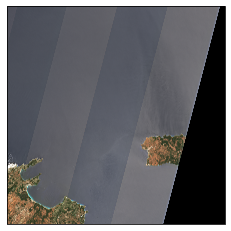

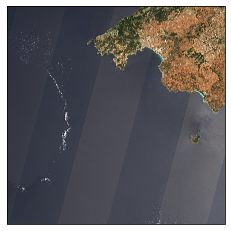

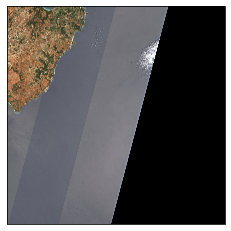

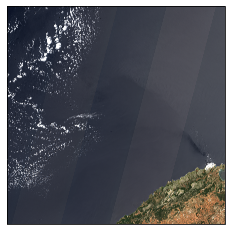

In [37]:
for ds in datasets:
    crs = ds.crs
    proj = ccrs.epsg(crs.split(':')[-1])

    fig, ax = plt.subplots(subplot_kw={'projection': proj})
    ax.imshow(ds.data.transpose(1, 2, 0), extent=extent)
    fig.show()

Tenemos cuatro piezas que unir para resolver nuestro pequeño rompecabezas. Vamos a seguir la misma técnica que antes usando `cartopy` y `matplotlib` pero modificando algunas pequeñas cosas.

El `crs` (el [sistema de referencia](https://docs.qgis.org/3.16/en/docs/gentle_gis_introduction/coordinate_reference_systems.html)) se puede ver que es el mismo en todos los casos. Como quiero unir las 4 piezas necesito una imagen que incluya a las 4. Para ello necesito saber las localizaciones mínimas y máximas del conjunto de las 4 imágenes (`x0`, `x1`, `y0`, `y1` en el código de más abajo). Y necesito saber la referencia de cada una de las imágenes individuales en la imagen común que estamos creando (`x_min`, `x_max`, `y_min`, `y_max` en el código de más abajo).

Con lo anterior podemos obtener la imagen final:

<ipython-input-38-abf5fbfbb6c9>:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


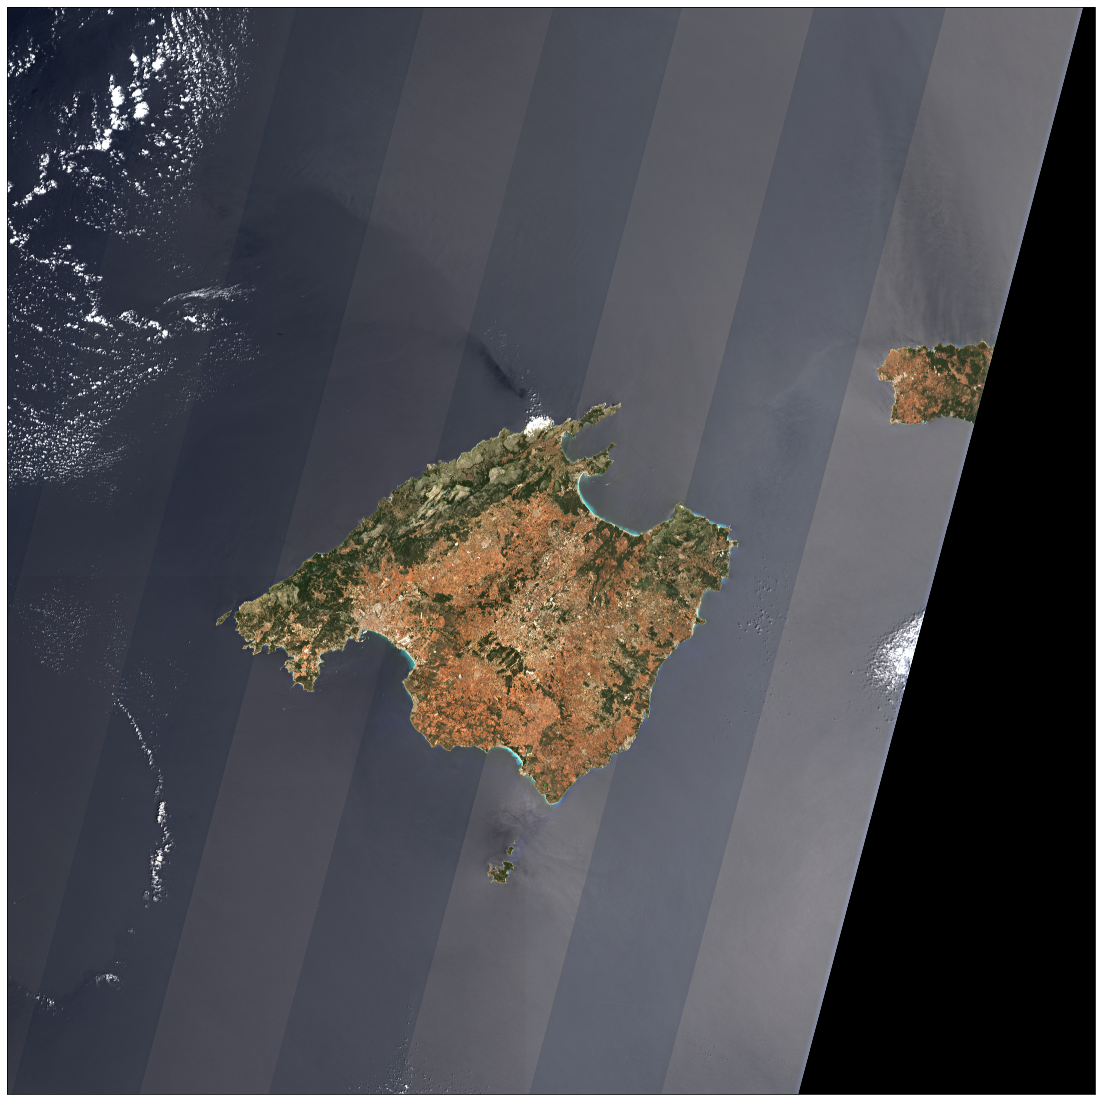

In [38]:
crs = datasets[0].crs
proj = ccrs.epsg(crs.split(':')[-1])

x0 = min([ds.x.values.min() for ds in datasets])
x1 = max([ds.x.values.max() for ds in datasets])
y0 = min([ds.y.values.min() for ds in datasets])
y1 = max([ds.y.values.max() for ds in datasets])

fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={'projection': proj})
ax.set_xlim(x0, x1)
ax.set_ylim(y0, y1)

for ds in datasets:
    x_min = ds.x.values.min()
    x_max = ds.x.values.max()
    y_min = ds.y.values.min()
    y_max = ds.y.values.max()
    extent = (x_min, x_max, y_min, y_max)
    ax.imshow(ds.data.transpose(1, 2, 0), extent=extent)
fig.show()

¡¡¡Qué isla tan bonita!!!

Pero, ¿qué son esas bandas que se ven por ahí? Puedes leer un poco sobre ello en la sección '*A few words on the post-processing*' en [este artículo de Pierre Markuse](https://pierre-markuse.net/2017/11/06/europe-mosaic-sentinel-hub-temporal-processing/). Corregir eso con Python daría para otro [artículo](https://www.sciencedirect.com/science/article/abs/pii/S0034425717304856). ¿Te animas a escribirlo?